In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
path = r"/Users/diegoalvarez/Desktop/CashTreasuries/data/RawGitHubData"

# Filtered Auction

These are the active coupons

In [29]:
def get_auction_info(path: str) -> pd.DataFrame:

    tmp_path = os.path.join(path, r"filtered_auctions.xlsx")
    
    df_key = (pd.read_excel(
        io = tmp_path, index_col = [0,1]).
        reset_index(drop = True).
        assign(
            auction_date = lambda x: pd.to_datetime(x.auction_date).dt.date,
            issue_date   = lambda x: pd.to_datetime(x.issue_date).dt.date))

    return df_key

df_key = get_auction_info(path)

# Historical Auctions == Historical Treasury Auctions -> TreasuryAuct

In [8]:
melt_cols = list(df_key.columns) + ["record_date"] + ["security_term"]

Work on ```historical auctions``` part

In [33]:
def _get_historical_auctions(path: str, melt_cols: list) -> pd.DataFrame:

    tmp_path = os.path.join(path, r"historical_auctions.xlsx")
    
    df_historical_auctions = (pd.read_excel(
        io = tmp_path, index_col = 0).
        melt(id_vars = melt_cols).
        dropna().
        assign(
            auction_date = lambda x: pd.to_datetime(x.auction_date).dt.date,
            issue_date   = lambda x: pd.to_datetime(x.issue_date).dt.date,
            record_date  = lambda x: pd.to_datetime(x.record_date).dt.date))

    return df_historical_auctions

df_historical_auctions = _get_historical_auctions(path, melt_cols)

Work on ```historical treasury auctions``` part

In [35]:
def _get_historical_treasury_auctions(path: str, melt_cols: list) -> pd.DataFrame: 

    tmp_path = os.path.join(path, r"Histroical_Treasury_Auctions.xlsx")
    
    df_historical = (pd.read_excel(
        io = tmp_path, index_col = 0).
        melt(id_vars = melt_cols).
        dropna().
        assign(
            auction_date = lambda x: pd.to_datetime(x.auction_date).dt.date,
            issue_date   = lambda x: pd.to_datetime(x.issue_date).dt.date,
            record_date  = lambda x: pd.to_datetime(x.record_date).dt.date))

    return df_historical

df_historical_treasury_auctions = _get_historical_treasury_auctions(path, melt_cols)

Now combine the two 

In [14]:
def combine_auction_data(melt_cols: list, df_historical_auctions: pd.DataFrame, df_historical_treasury_auctions: pd.DataFrame) -> pd.DataFrame:
    
    merge_cols = melt_cols + ["variable"]
    
    df_left = (df_historical_auctions.rename(
        columns = {"value": "from_historical_auctions"}))
    
    df_right = (df_historical_treasury_auctions.rename(
        columns = {"value": "from_historical_treasury_auctions"}))
    
    df_combined = (df_left.merge(
        right = df_right, how = "outer", on = merge_cols))
    
    df_out = (df_combined.assign(
        new_val = lambda x: np.where(
            x.from_historical_auctions != x.from_historical_treasury_auctions,
            np.nan,
            x.from_historical_treasury_auctions)).
        assign(new_val = lambda x: x.new_val.fillna(x.from_historical_auctions)).
        assign(new_val = lambda x: x.new_val.fillna(x.from_historical_treasury_auctions)).
        drop(columns = ["from_historical_treasury_auctions", "from_historical_auctions"]))

    return df_out

df_combined = combine_auction_data(melt_cols, df_historical_auctions, df_historical_treasury_auctions)

# market_observed_treasuries.xlsx

In [374]:
def combine_observed_treasuries(path: str) -> pd.DataFrame:

    files = [os.path.join(path, file) for file in os.listdir(path) if len(file.split("_")) == 6]
    
    df_observed = (pd.concat([
        pd.read_excel(io = file, index_col = 0).assign(group = file.split("/")[-1].split(".")[0].split("usts_")[-1])
        for file in files]).
        melt(id_vars = ["Action", "Description", "group", "last_updated"]).
        dropna().
        drop_duplicates())
    
    df_out = (df_observed.groupby(
        ["Action", "Description", "group", "last_updated", "variable"]).
        head(1).
        pivot(index = ["Action", "Description", "last_updated", "variable"], columns = "group", values = "value").
        reset_index().
        assign(new_val = 
               lambda x: np.where(
                   (x.auctioned_after_2000 == x.auctioned_after_2005) & (x.auctioned_after_2005 == x.auctioned_after_2010),
                   x.auctioned_after_2000,
                   np.nan)).
        assign(new_val = lambda x: x.new_val.fillna(x.auctioned_after_2000)).
        assign(new_val = lambda x: x.new_val.fillna(x.auctioned_after_2005)).
        assign(new_val = lambda x: x.new_val.fillna(x.auctioned_after_2010)).
        drop(columns = ["auctioned_after_2000", "auctioned_after_2005", "auctioned_after_2010"]))

    return df_out

df_observed = combine_observed_treasuries(path)

In [5]:
import sys
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CashTreasuries\root\src")

In [6]:
from CUSIPDataCollect import GitHubCollector

In [7]:
df = GitHubCollector().get_cleaned_historical_ct_yield()

Working on 10-Year
Working on 13-Week
Working on 17-Week
Working on 2-Year
Working on 20-Year
Working on 26-Week
Working on 3-Year
Working on 30-Year
Working on 4-Week
Working on 5-Year
Working on 52-Week
Working on 7-Year
Working on 8-Week


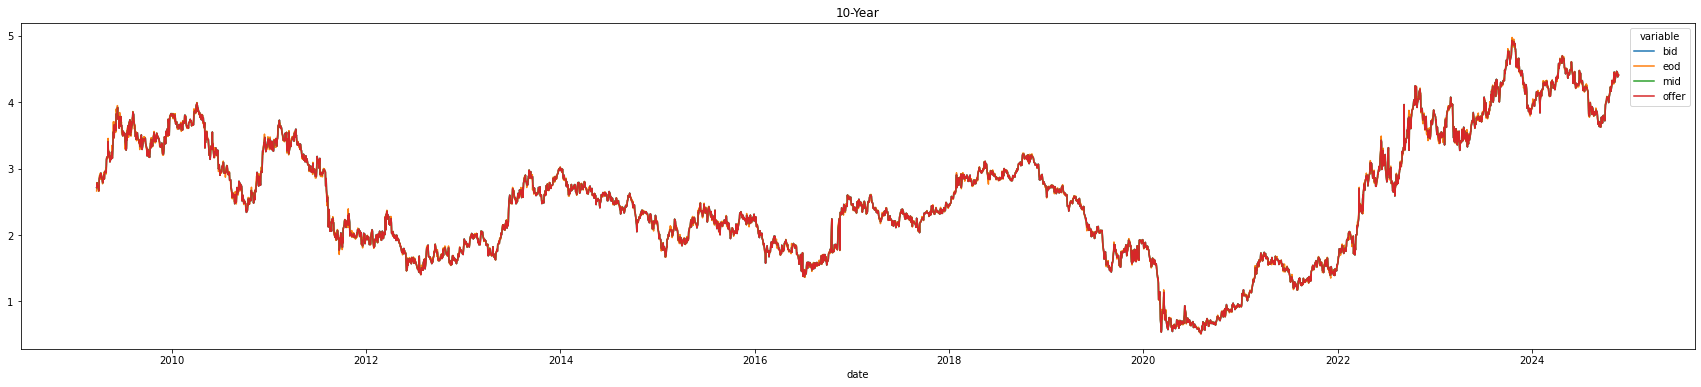

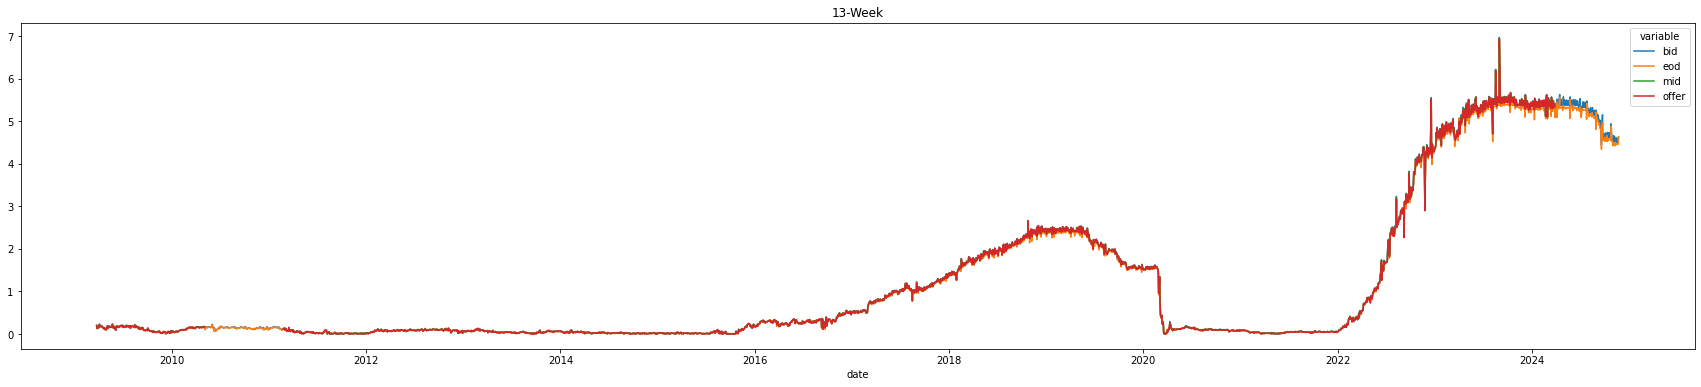

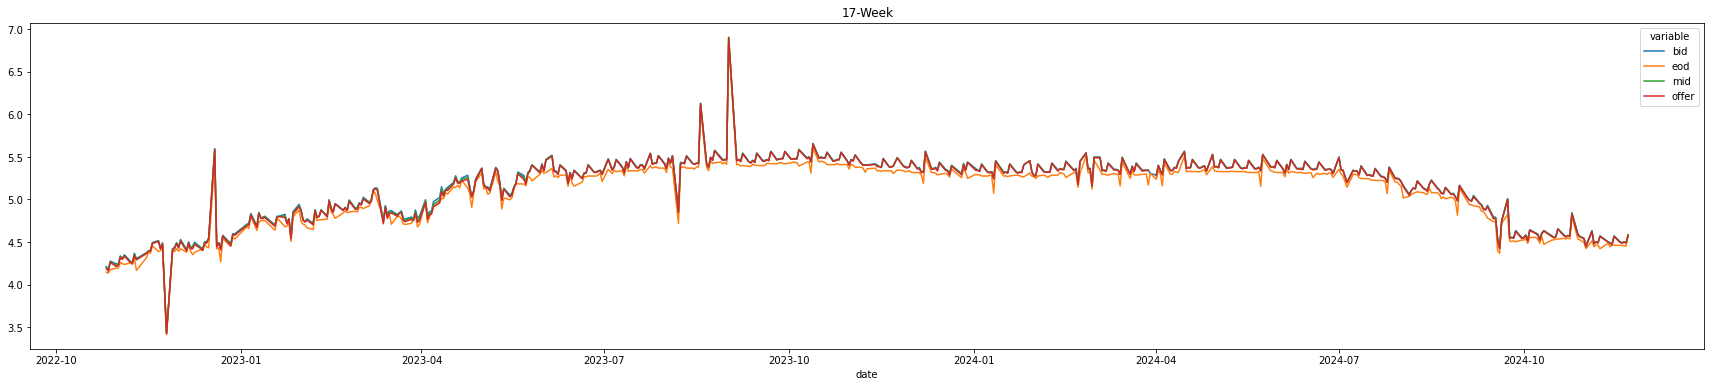

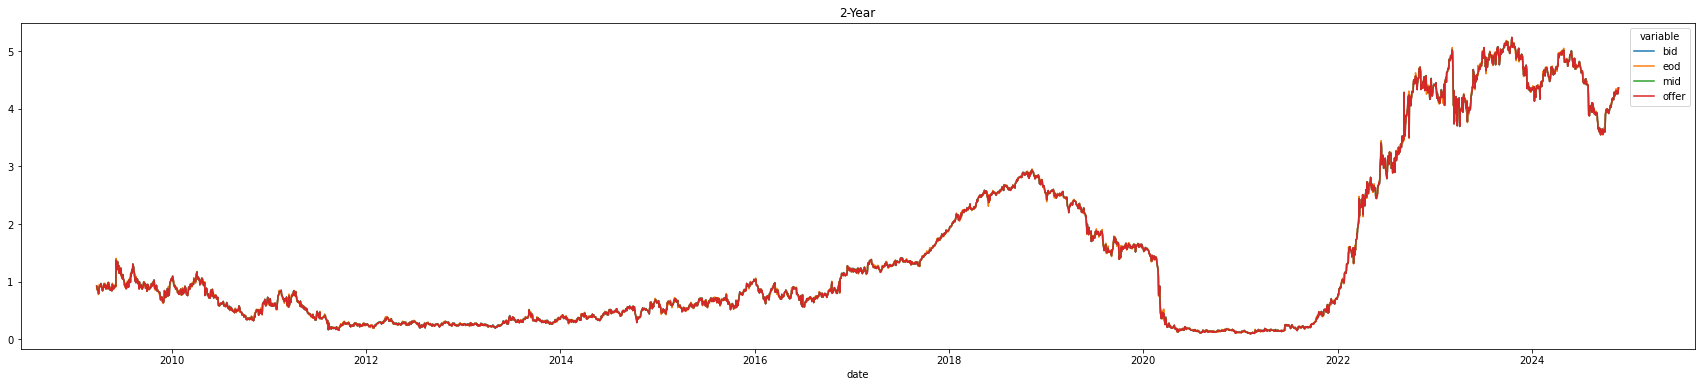

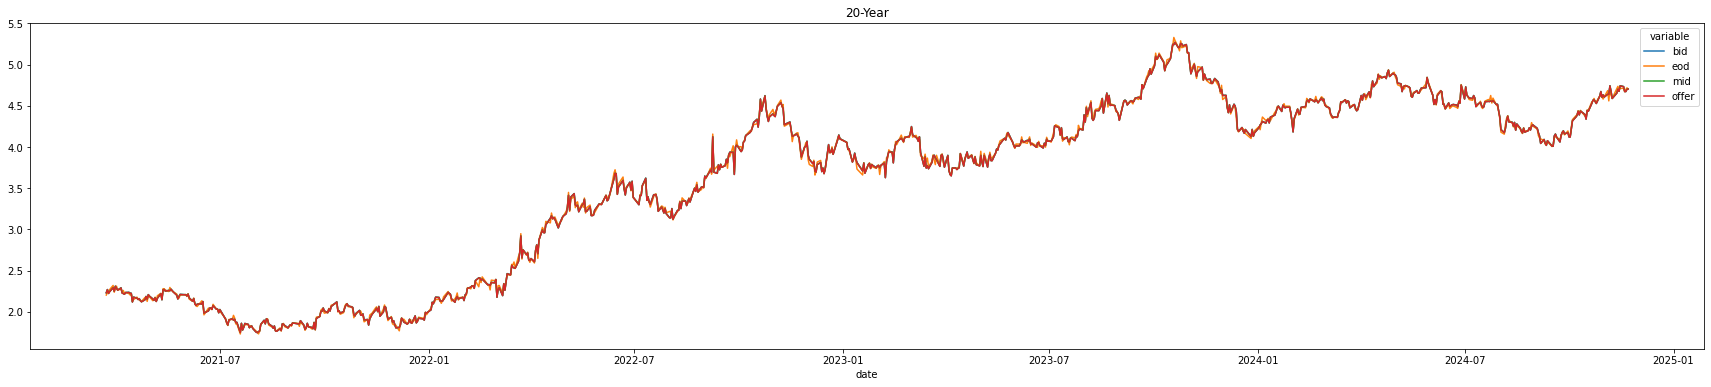

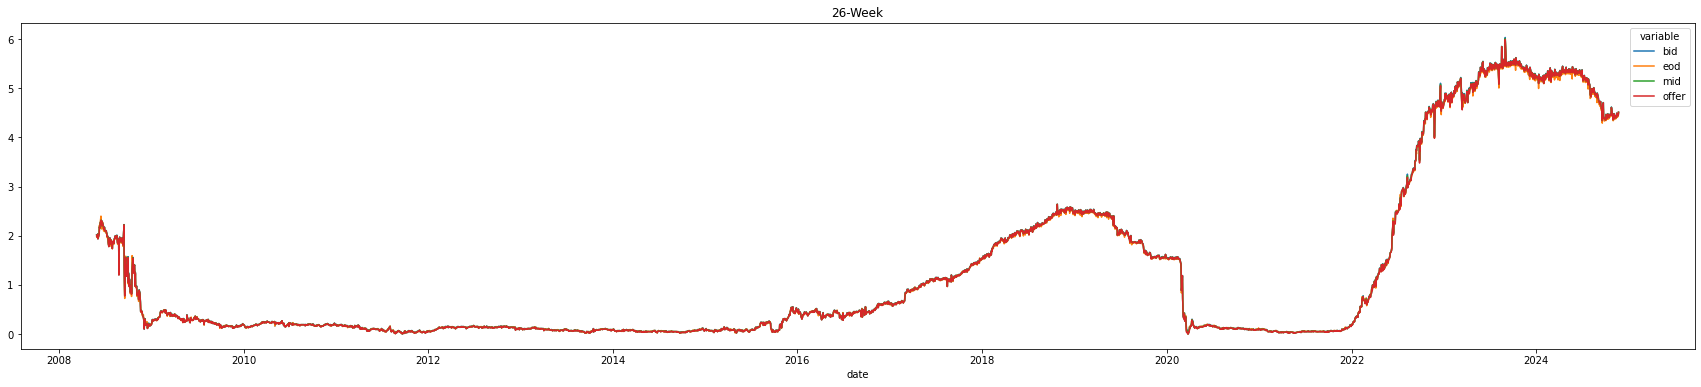

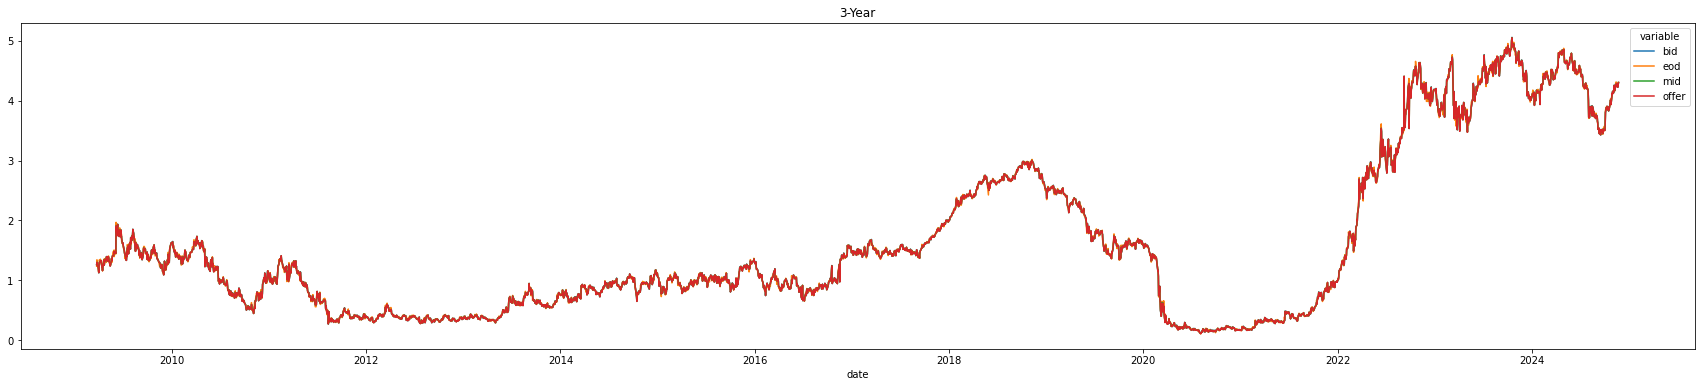

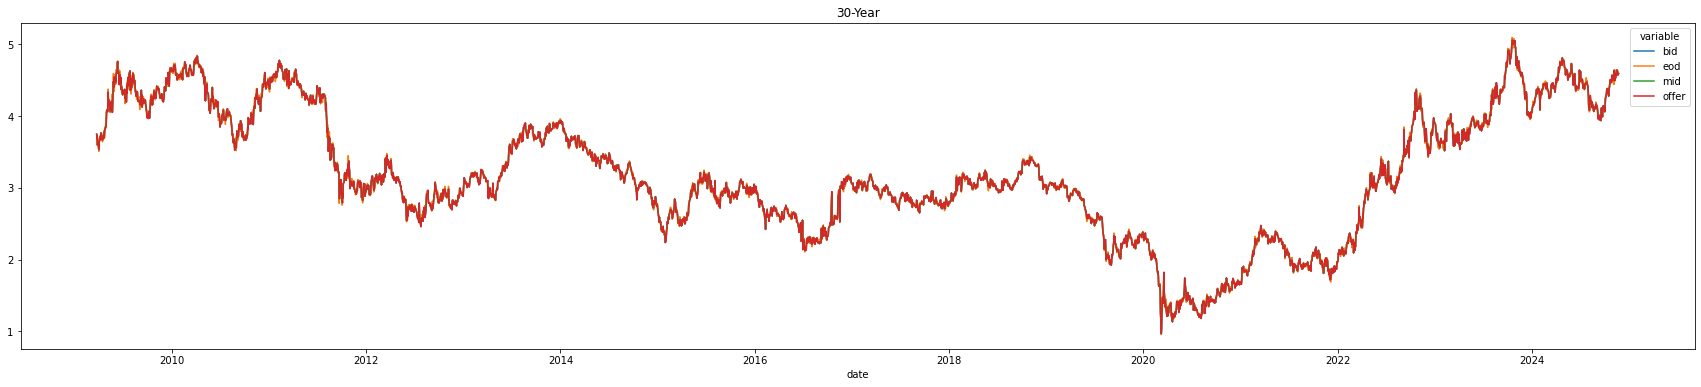

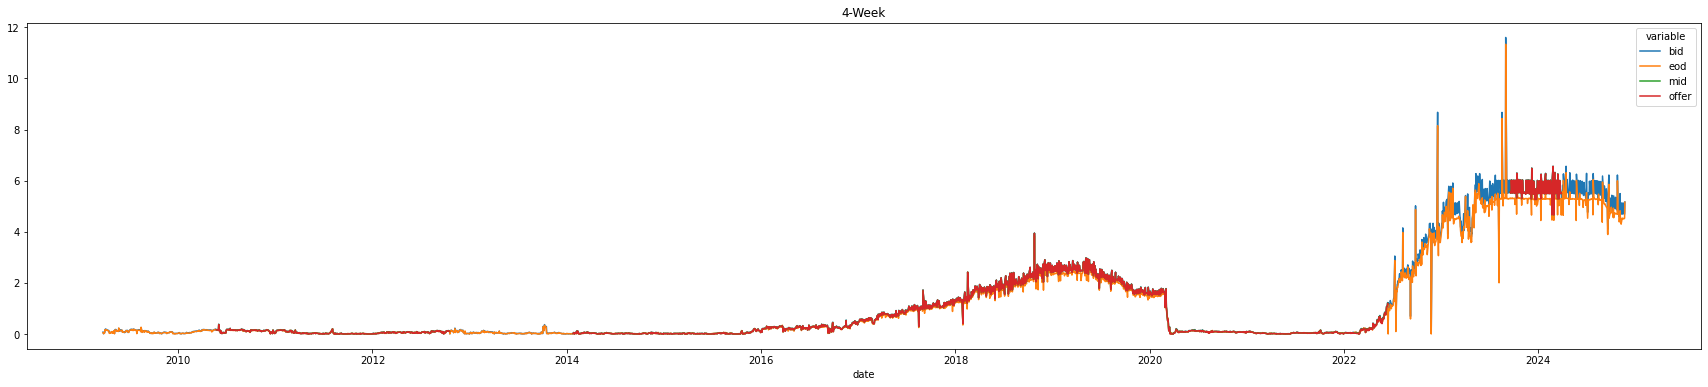

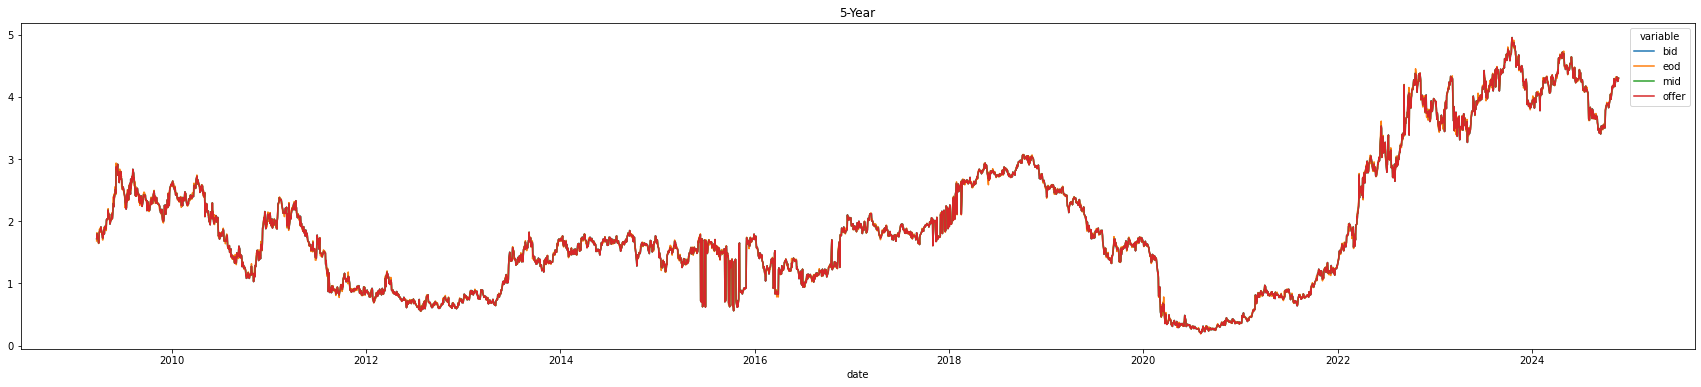

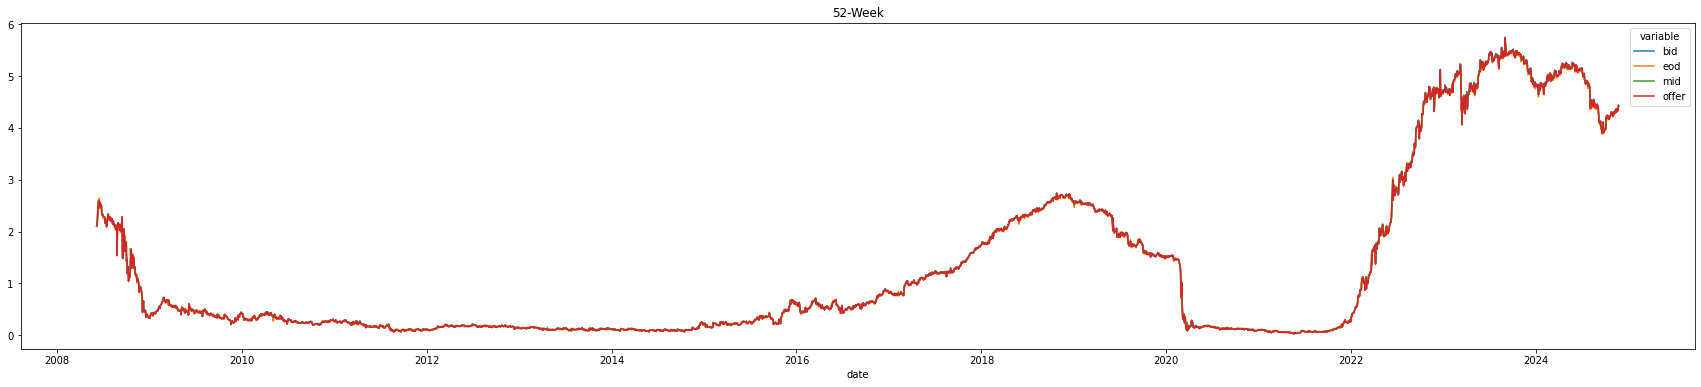

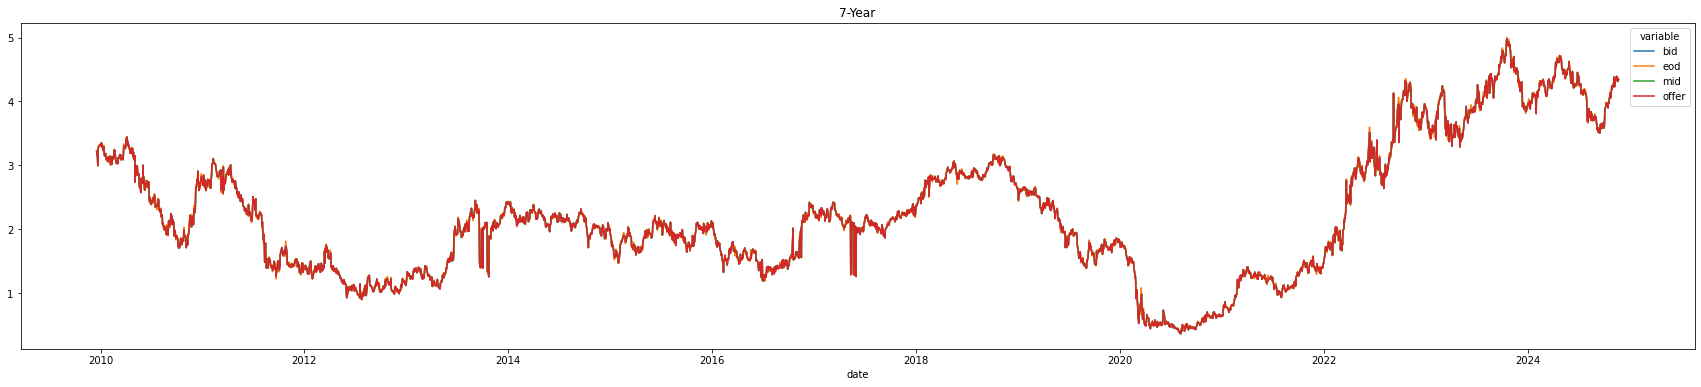

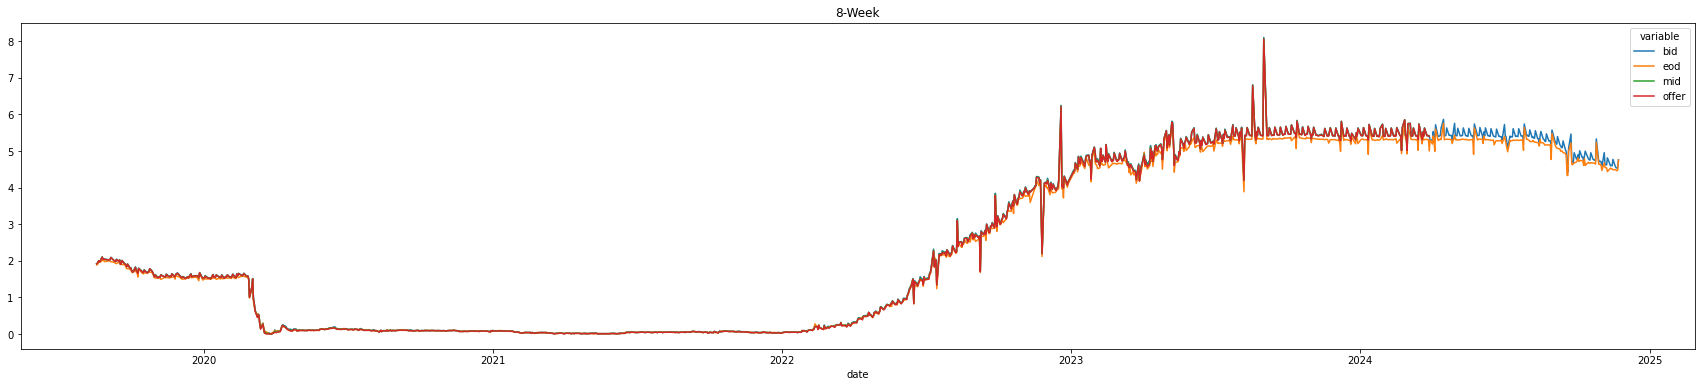

In [14]:
tenors = df.tenor.drop_duplicates().to_list()
for tenor in tenors:
    
    (df.query(
        "tenor == @tenor")
        [["date", "variable", "replace_value"]].
        pivot(index = "date", columns = "variable", values = "replace_value").
        plot(
            figsize = (30,6),
            title   = tenor))

In [15]:
print(os.getcwd())

C:\Users\Diego\Desktop\app_prod\research\CashTreasuries\root\notebooks
